In [3]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)

    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

Processing location A...
Processing location B...
Processing location C...


# Feature enginering

In [4]:
# temporary
X_train["hour"] = X_train.index.hour
X_train["weekday"] = X_train.index.weekday
X_train["month"] = X_train.index.month
X_train["year"] = X_train.index.year

X_test["hour"] = X_test.index.hour
X_test["weekday"] = X_test.index.weekday
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year


to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,92951,165,,,6.017608,2.714546,0.5,4.0,5.4,7.8,17.5,float32,73,0.000785,float,numeric,
air_density_2m:kgm3,92951,293,,,1.255435,0.036608,1.139,1.23,1.255,1.279,1.441,float32,73,0.000785,float,numeric,
ceiling_height_agl:m,72276,40993,,,2802.588135,2521.408447,27.799999,1037.099976,1803.25,3814.824951,12431.299805,float32,20748,0.223039,float,numeric,
clear_sky_energy_1h:J,92951,48602,,,515154.09375,820525.5,0.0,0.0,4544.899902,778247.25,3006697.25,float32,73,0.000785,float,numeric,
clear_sky_rad:W,92951,7815,,,143.101379,228.507324,0.0,0.0,0.0,220.949997,835.299988,float32,73,0.000785,float,numeric,
cloud_base_agl:m,84404,34862,,,1692.934692,1790.963745,27.4,572.200012,1128.550049,2016.699951,11688.900391,float32,8620,0.092664,float,numeric,
dew_or_rime:idx,92951,3,,,0.007025,0.246032,-1.0,0.0,0.0,0.0,1.0,float32,73,0.000785,float,category,
dew_point_2m:K,92951,436,,,275.237762,6.83461,247.300003,270.700012,275.0,280.5,293.799988,float32,73,0.000785,float,numeric,
diffuse_rad:W,92951,2870,,,39.495815,60.647518,0.0,0.0,0.0,66.0,340.100006,float32,73,0.000785,float,numeric,
diffuse_rad_1h:J,92951,48553,,,142180.03125,215907.21875,0.0,0.0,9951.700195,236502.75,1182265.375,float32,73,0.000785,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,2160,106,,,8.206482,2.201396,3.2,6.6,8.0,10.0,14.2,float32,,,float,numeric,
air_density_2m:kgm3,2160,153,,,1.232807,0.032116,1.142,1.209,1.238,1.26,1.301,float32,,,float,numeric,
ceiling_height_agl:m,1473,1391,,,2938.389648,2913.641113,30.6,891.799988,1553.900024,4021.300049,11468.0,float32,687,0.318056,float,numeric,
clear_sky_energy_1h:J,2160,1807,,,1227746.75,1104468.625,0.0,64338.124023,1056303.125,2372037.5,3005707.0,float32,,,float,numeric,
clear_sky_rad:W,2160,1044,,,341.056641,307.729095,0.0,13.65,273.849991,646.874985,835.099976,float32,,,float,numeric,
cloud_base_agl:m,1879,1771,,,1797.160156,2046.394409,29.799999,486.899994,997.799988,2298.300049,11467.799805,float32,281,0.130093,float,numeric,
dew_or_rime:idx,2160,3,,,0.040741,0.202365,-1.0,0.0,0.0,0.0,1.0,float32,,,float,category,
dew_point_2m:K,2160,202,,,280.783203,4.378817,268.0,277.899994,281.0,284.299988,290.200012,float32,,,float,numeric,
diffuse_rad:W,2160,985,,,84.915688,78.422508,0.0,6.925,73.700001,135.600006,312.600006,float32,,,float,numeric,
diffuse_rad_1h:J,2160,1806,,,305696.5,278146.25,0.0,36756.901367,272526.046875,488256.03125,1086246.25,float32,,,float,numeric,


**Types warnings summary**

,train_data,test_data,warnings
estimated_diff_hours,float,int,warning
y,float,--,warning


### Feature Distance

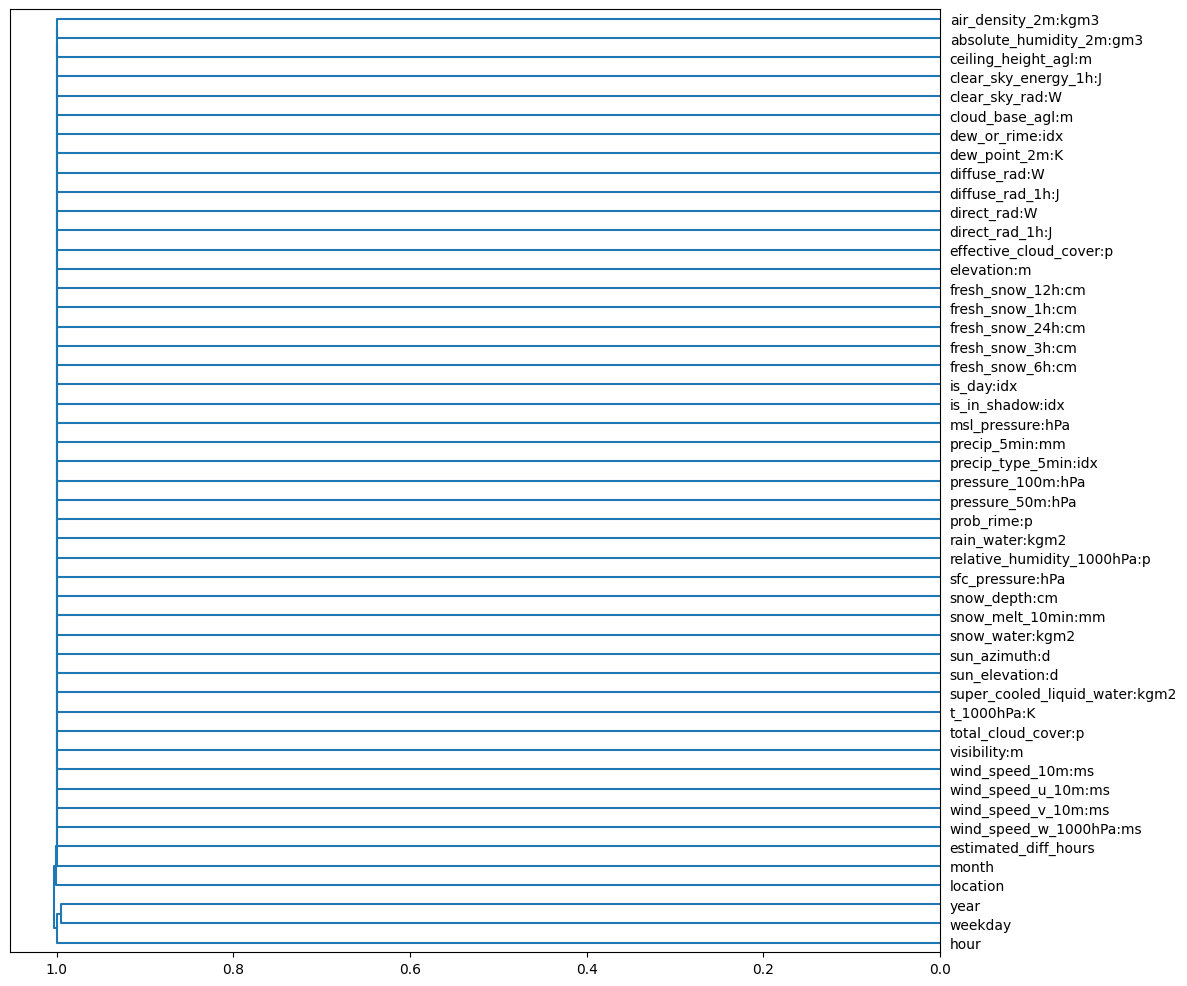

In [5]:
import autogluon.eda.auto as auto
auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,295.26029,787.46272,-0.0,0.0,0.0,176.4,5365.36,float64,2539,,,float,


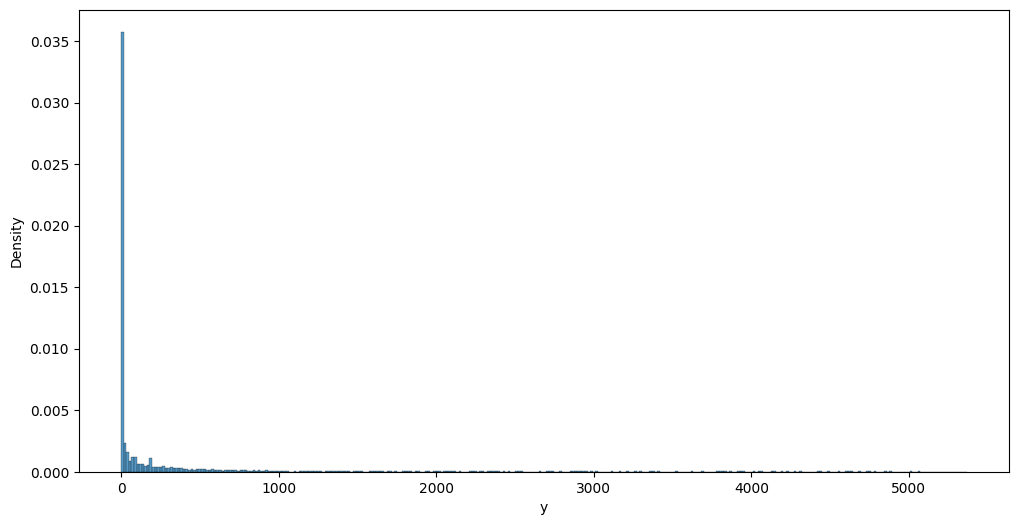

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

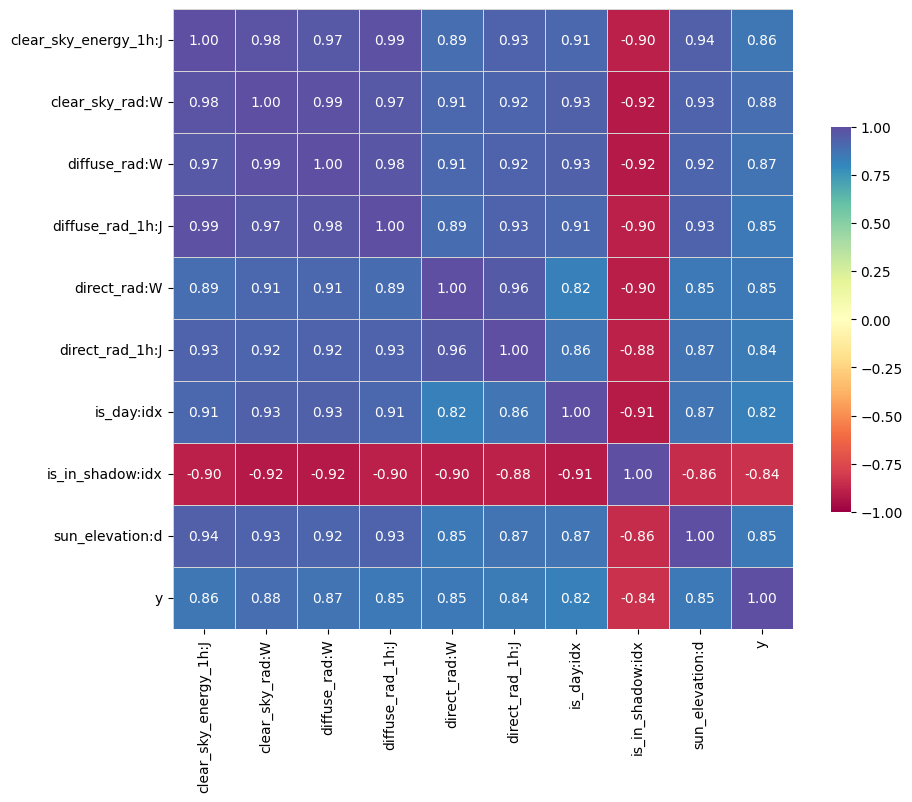

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

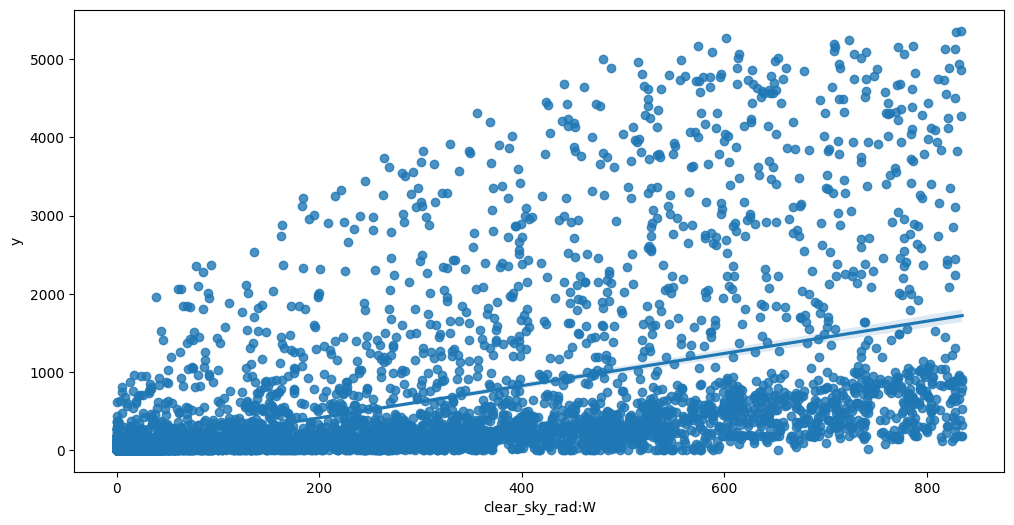

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

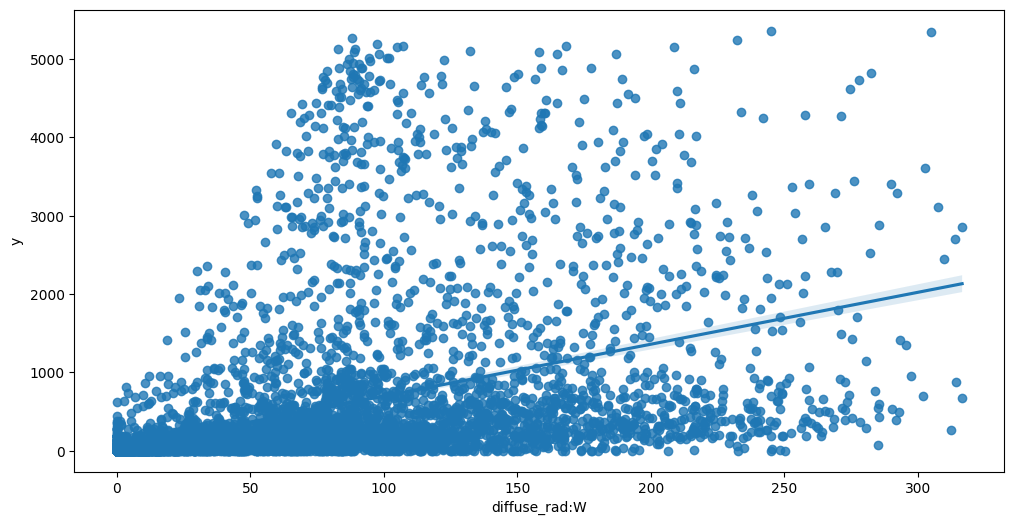

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

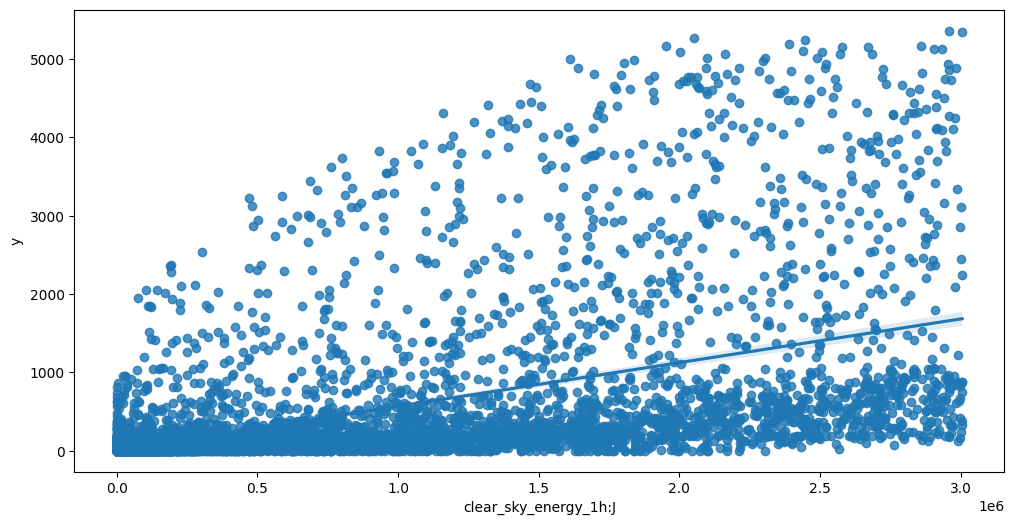

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

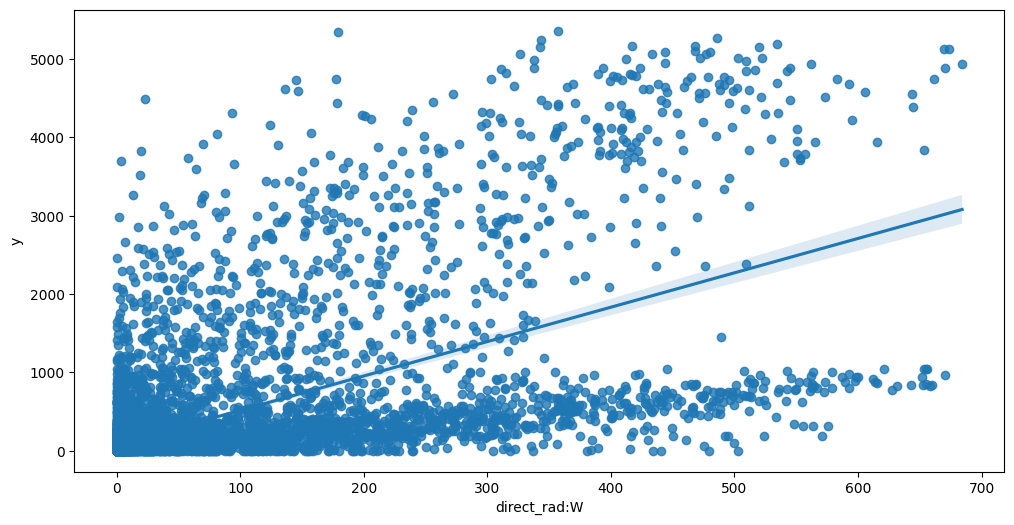

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

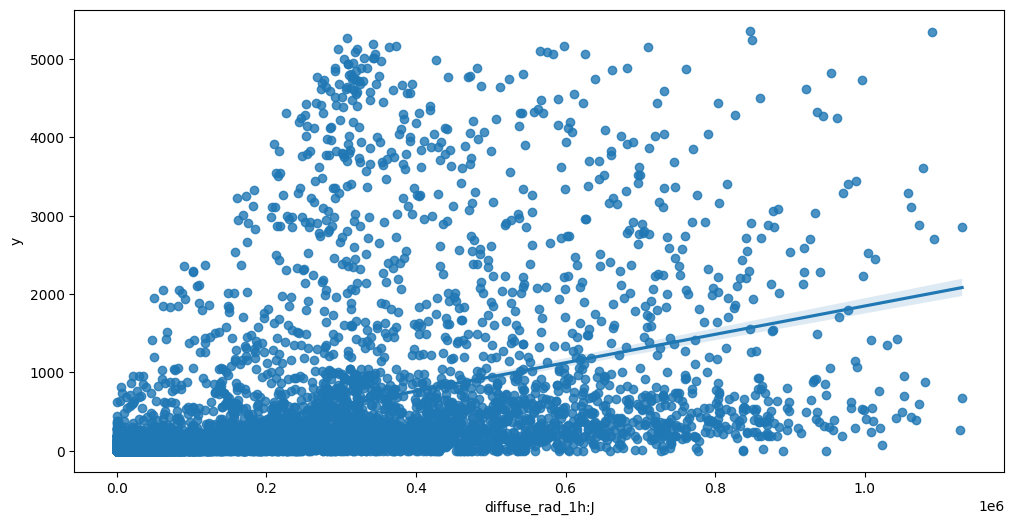

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

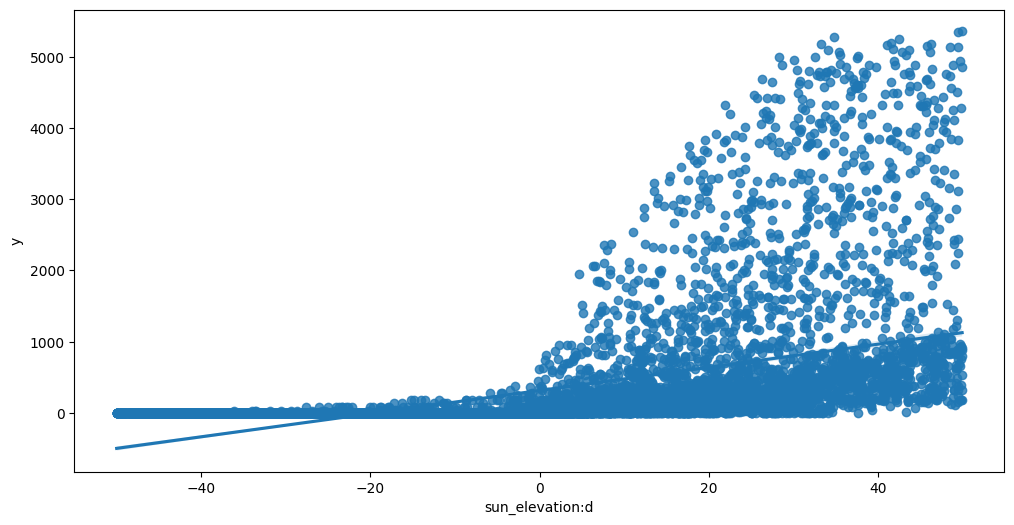

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

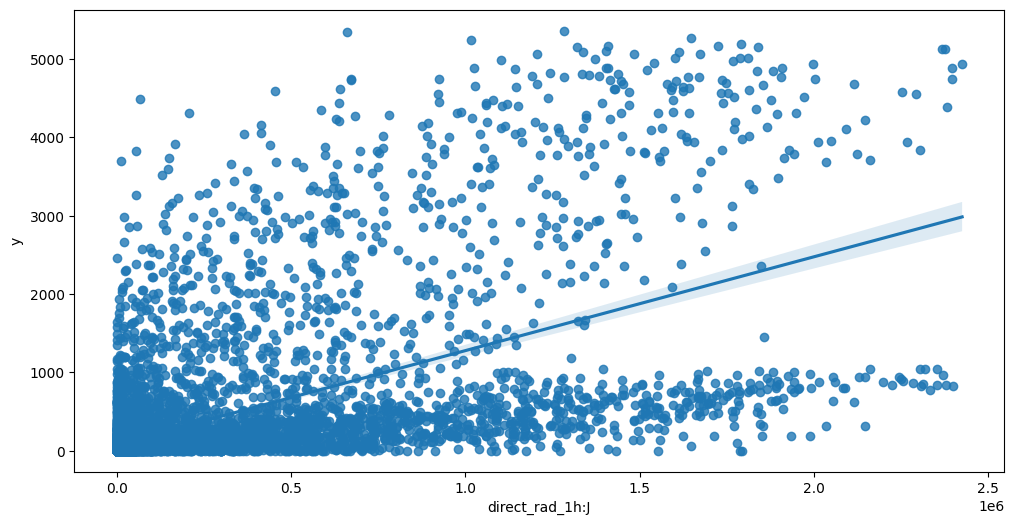

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

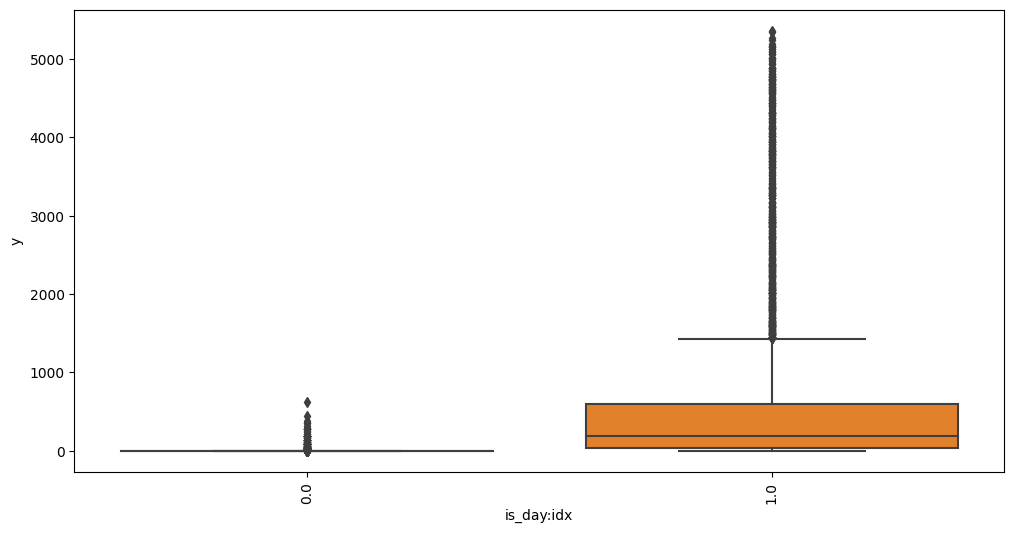

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

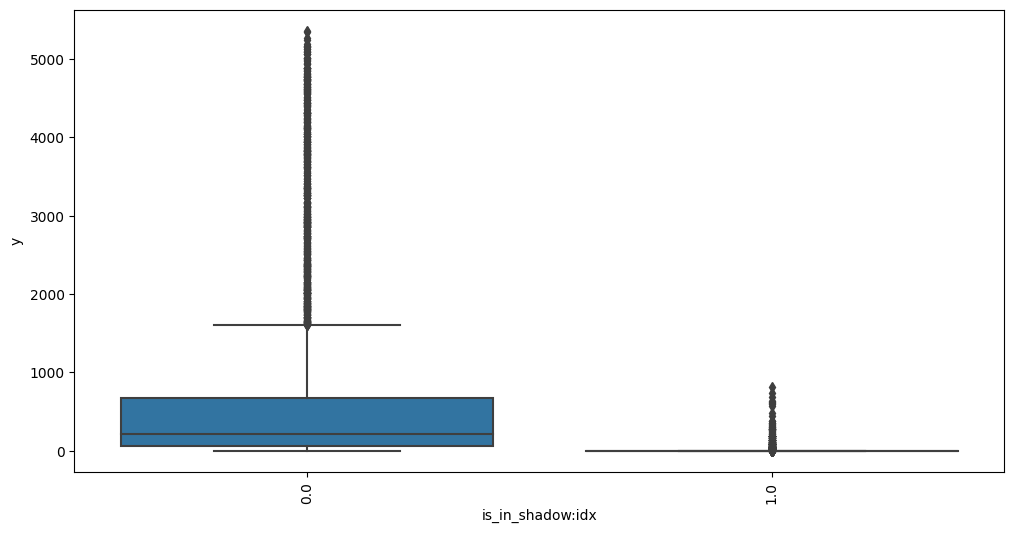

In [6]:
auto.target_analysis(train_data=X_train, label="y")

No path specified. Models will be saved in: "AutogluonModels/ag-20231006_194105/"


### Model Prediction for y

Using validation data for `Test` points

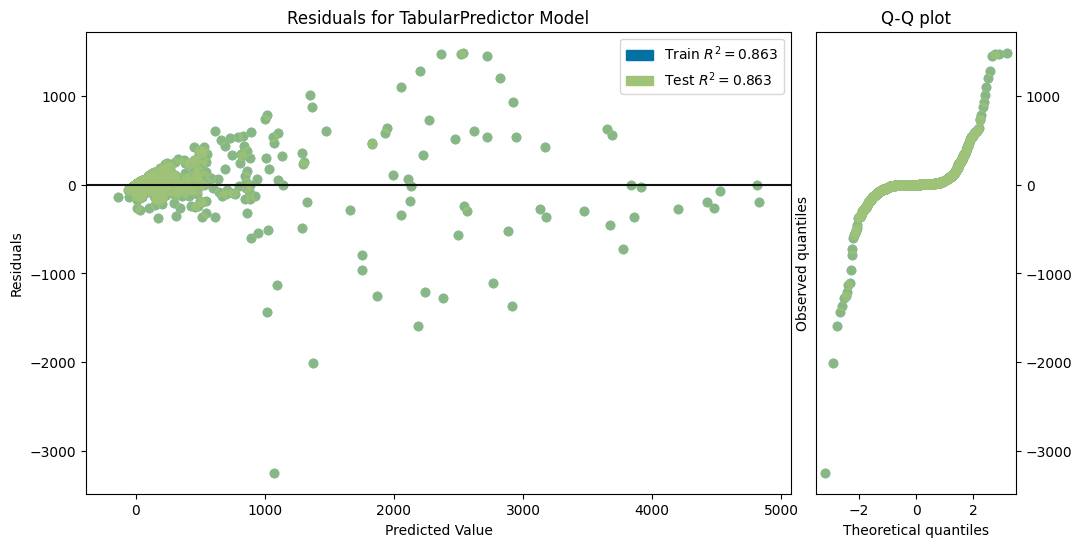

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-253.056937,-272.536784,0.032055,0.023147,79.745794,0.032055,0.023147,79.745794,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
location,253.687018,11.093018,4.376035e-07,5,276.527696,230.846340
direct_rad:W,226.920962,13.230996,1.380660e-06,5,254.163766,199.678158
elevation:m,86.370572,9.141371,1.483558e-05,5,105.192781,67.548363
clear_sky_rad:W,70.535379,3.159383,4.817277e-07,5,77.040593,64.030165
sun_elevation:d,34.856988,2.368661,2.543106e-06,5,39.734094,29.979882
hour,21.416170,4.937013,3.161608e-04,5,31.581547,11.250793
diffuse_rad:W,16.415674,2.701119,8.487960e-05,5,21.977315,10.854034
sun_azimuth:d,7.758900,2.762299,1.640645e-03,5,13.446511,2.071288
effective_cloud_cover:p,7.349483,2.150437,7.874877e-04,5,11.777262,2.921703
clear_sky_energy_1h:J,6.956073,1.790579,4.833607e-04,5,10.642900,3.269247


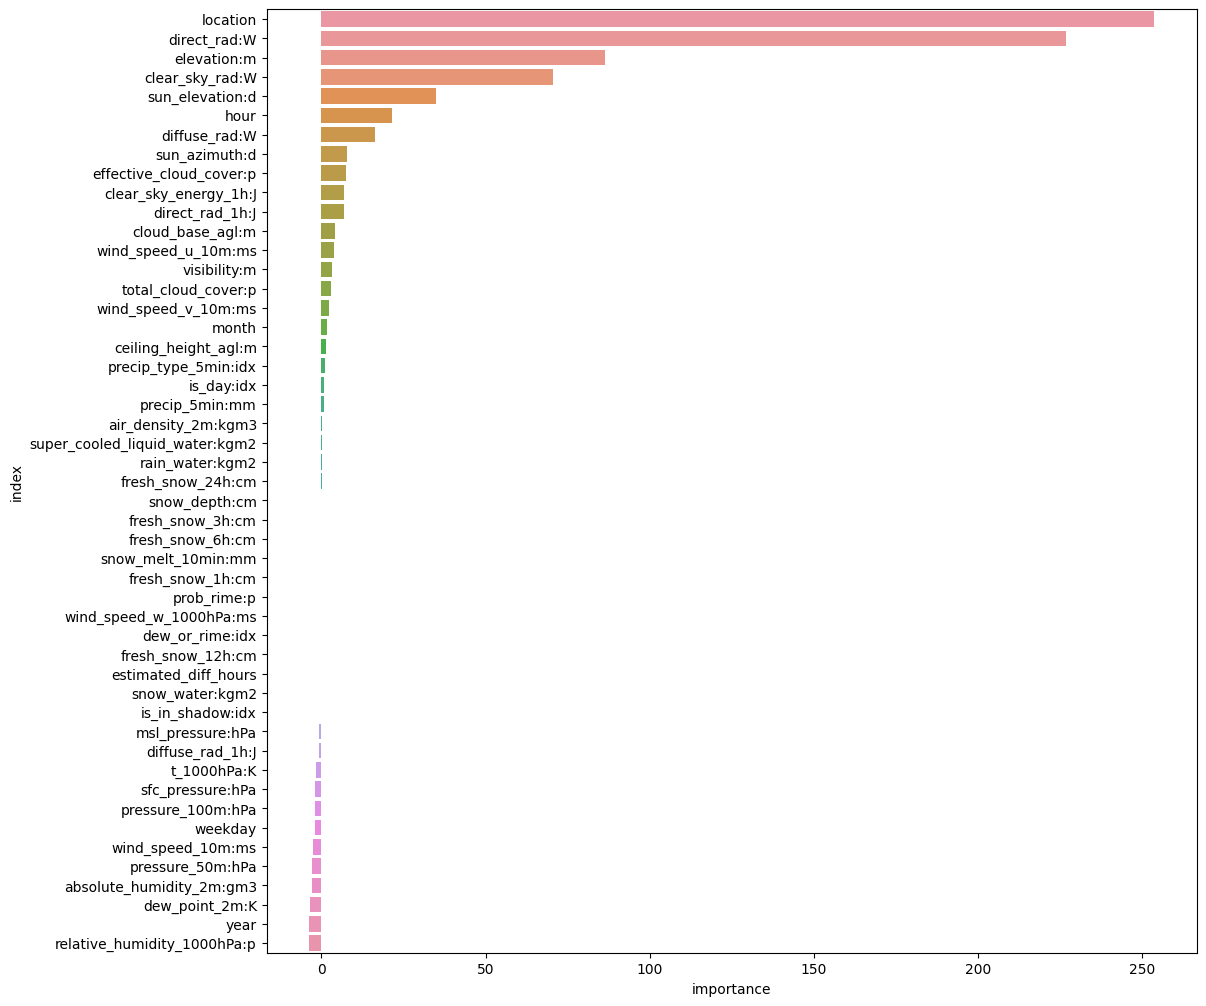

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,estimated_diff_hours,location,hour,weekday,month,year,y,y_pred,error
ds,,,,,,,,,,,,,,,,,,,,,
2021-08-31 12:00:00,10.6,1.240,932.400024,2157642.500,593.000000,210.199997,0.0,285.100006,160.399994,538968.31250,...,0.0,0.0,A,12,1,8,2021,4317.50,1070.937378,3246.562622
2021-08-08 14:00:00,12.6,1.187,2565.199951,2323323.000,605.400024,468.100006,0.0,288.100006,153.399994,630367.50000,...,0.0,0.0,A,14,6,8,2021,3386.02,1374.843384,2011.176616
2020-08-02 08:00:00,12.9,1.187,5464.700195,1766310.500,549.000000,2839.399902,0.0,288.500000,212.500000,661382.62500,...,0.0,0.0,A,8,6,8,2020,3781.14,2184.002686,1597.137314
2022-08-27 13:00:00,9.1,1.219,2247.300049,2161148.000,575.099976,772.200012,0.0,282.899994,173.300003,591917.18750,...,0.0,0.0,A,13,5,8,2022,1046.54,2535.344971,1488.804971
2020-03-23 10:00:00,4.1,1.258,2168.000000,1438440.125,432.500000,2168.000000,0.0,271.100006,166.500000,533134.18750,...,-0.0,0.0,A,10,0,3,2020,890.12,2368.071777,1477.951777
2020-07-22 09:00:00,7.3,1.232,1483.199951,2303324.500,685.900024,682.500000,0.0,279.600006,162.399994,543060.18750,...,-0.0,0.0,A,9,2,7,2020,1047.20,2520.609375,1473.409375
2020-05-13 14:00:00,3.6,1.267,4821.700195,2424107.500,630.400024,787.700012,0.0,269.299988,224.000000,847436.31250,...,-0.0,0.0,A,14,2,5,2020,1261.48,2718.240234,1456.760234
2022-05-28 13:00:00,7.4,1.249,703.000000,2817063.250,757.200012,323.500000,0.0,279.399994,101.199997,383728.40625,...,0.0,0.0,A,13,5,5,2022,2460.04,1021.623047,1438.416953
2019-06-15 11:00:00,10.0,1.209,2796.600098,2958760.250,833.500000,2796.600098,0.0,284.600006,271.100006,944208.62500,...,0.0,0.0,A,11,5,6,2019,4274.16,2912.580566,1361.579434


In [7]:
auto.quick_fit(X_train, "y", show_feature_importance_barplots=True, val_size=0.1)

# Starting

In [11]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 70
Now creating submission number: 71


In [12]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'

In [13]:
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}").fit(train_data, presets=presets, time_limit=time_limit)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_71/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.18 GB / 494.38 GB (0.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    93024
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 287.01965, 766.40778)
	If 'regression' is not the correct problem_type, please manually specify the problem_type

In [ ]:
predictors = [predictor, predictor, predictor]

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_all.ipynb"])

In [ ]:
predictor.fit_summary(show_plot=True)

In [ ]:
predictor.feature_importance(train_data)

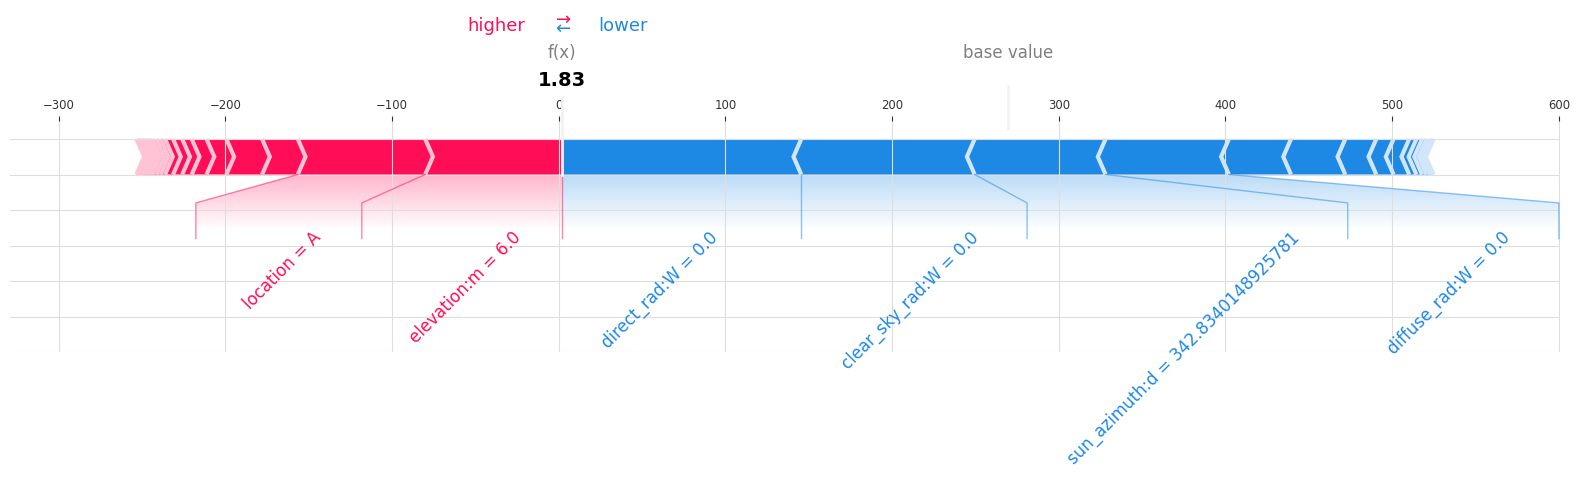

In [17]:
auto.explain_rows(train_data=X_train, model=predictor, plot="force", rows=X_train[:2])

In [ ]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_all.ipynb"])